In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2

In [2]:
#对比展现原始图片和对抗样本图片
def show_images_diff(original_img,original_label,adversarial_img,adversarial_label):
    import matplotlib.pyplot as plt
    plt.figure()

    #归一化
    if original_img.any() > 1.0:
        original_img=original_img/255.0
    if adversarial_img.any() > 1.0:
        adversarial_img=adversarial_img/255.0

    plt.subplot(131)
    plt.title('Original')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(132)
    plt.title('Adversarial')
    plt.imshow(adversarial_img)
    plt.axis('off')

    plt.subplot(133)
    plt.title('Adversarial-Original')
    difference = adversarial_img - original_img
    #(-1,1)  -> (0,1)
    difference=difference / abs(difference).max()/2.0+0.5
    plt.imshow(difference,cmap=plt.cm.gray)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [3]:
#获取计算设备 默认是CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#图像加载以及预处理
image_path="picture/cropped_panda.jpg"
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)

print(img.shape)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

img = Variable(torch.from_numpy(img).to(device).float())
print(img.shape)

#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()

label=np.argmax(model(img).data.cpu().numpy())
print("label={}".format(label))


(224, 224, 3)
torch.Size([1, 3, 224, 224])
label=388


In [4]:
#图像数据梯度可以获取
img.requires_grad = True

#设置为不保存梯度值 自然也无法修改
for param in model.parameters():
    param.requires_grad = False
    
optimizer = torch.optim.Adam([img])
loss_func = torch.nn.CrossEntropyLoss()

epochs=100
e=0.001

target=288
target=Variable(torch.Tensor([float(target)]).to(device).long())

for epoch in range(epochs):
    
    # forward + backward
    output = model(img)

    loss = loss_func(output, target)
    label=np.argmax(output.data.cpu().numpy())
    
    print("epoch={} loss={} label={}".format(epoch,loss,label))
    
    #如果定向攻击成功
    if label == target:
        print("")
        break
         
    #梯度清零
    optimizer.zero_grad()
    #反向传递 计算梯度   
    loss.backward()
    
    img.data=img.data-e*torch.sign(img.grad.data)


epoch=0 loss=12.660843849182129 label=388
epoch=1 loss=11.619282722473145 label=388
epoch=2 loss=10.685437202453613 label=388
epoch=3 loss=9.860589981079102 label=388
epoch=4 loss=9.152616500854492 label=388
epoch=5 loss=8.53160572052002 label=388
epoch=6 loss=7.990605354309082 label=388
epoch=7 loss=7.49136209487915 label=388
epoch=8 loss=7.034764289855957 label=388
epoch=9 loss=6.609021186828613 label=388
epoch=10 loss=6.200308799743652 label=388
epoch=11 loss=5.787776947021484 label=388
epoch=12 loss=5.362033843994141 label=388
epoch=13 loss=4.9248762130737305 label=388
epoch=14 loss=4.498962879180908 label=388
epoch=15 loss=4.08840274810791 label=388
epoch=16 loss=3.6776788234710693 label=388
epoch=17 loss=3.285874366760254 label=388
epoch=18 loss=2.9292404651641846 label=388
epoch=19 loss=2.581559181213379 label=290
epoch=20 loss=2.232889413833618 label=290
epoch=21 loss=1.9422016143798828 label=290
epoch=22 loss=1.6929763555526733 label=288



c:\Users\deadf\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [1, 3, 224, 224], strides() = [3, 1, 672, 3]
param.sizes() = [1, 3, 224, 224], strides() = [150528, 1, 672, 3] (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch/csrc/autograd/functions/accumulate_grad.h:192.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


(3, 224, 224)


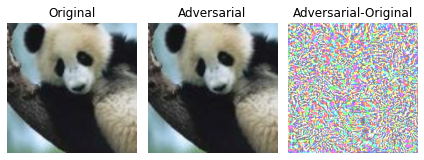

In [5]:
adv=img.data.cpu().numpy()[0]
print(adv.shape)
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 255.0
adv = np.clip(adv, 0, 255).astype(np.uint8)

show_images_diff(orig,388,adv,target.data.cpu().numpy()[0])